In [ ]:
!nvidia-smi #view GPU
import os
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive'
os.chdir(path)
os.listdir() #!ls

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import json
import csv
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
% matplotlib inline


!pip3 install pytorch-pretrained-bert
from pytorch_pretrained_bert import BertTokenizer, BertModel#if "ImportError: cannot import name 'IPV6_ADDRZ_RE' " do"!pip install -Iv botocore==1.17"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer.convert_ids_to_tokens([101,2048,2402,7752,1012]))
#bert_model = BertModel.from_pretrained('bert-base-uncased')
#bert_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

100%|██████████| 231508/231508 [00:00<00:00, 29055774.57B/s]

['[CLS]', 'two', 'young', 'sink', '.']
cuda


#Get Entailment List from Corpus

In [ ]:
def extract_tokens_from_binary_parse(text, start_token):
  text = text.rstrip().strip()#去掉句首尾空格
  if start_token==True:
    text = '[CLS] ' + text + ' [SEP]' 
  else:
    text = text + ' [SEP]' 
  return text.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()

def getEntailment2List(path):
  source_target = []
  for i, line in enumerate(open(path)):#enumerate给每行/每个字典加了一个数字编号,每一行都是一个单独的字典
    data = json.loads(line)#一个data就是一行数据
    #json.loads将已编码的JSON字符串解码为Python对象,JSON对象无法正常,即line无法当字典来正常使用。此处在for循环中，依次对每行进行解码
    label = data['gold_label']#取出该行的标签#本质上是从字典中取出key->value,'gold_label'是key。
    if label == 'entailment':
      s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse'],True))
      s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse'],False))    
      source_target.append([s1, s2, len(s1.split(" "))])
  return source_target

In [ ]:
data_path = './Colab Notebooks/Entailment_generation/snli_1.0/'
if 0:
  train_list = getEntailment2List(os.path.join(data_path,'snli_1.0_train.jsonl'))
  dev_list =   getEntailment2List(os.path.join(data_path,'snli_1.0_dev.jsonl'))
  test_list =  getEntailment2List(os.path.join(data_path,'snli_1.0_test.jsonl'))

#Write in csv

In [ ]:
if 0:
  header = ['source','target','len of src']

  list_write =pd.DataFrame(columns=header,data=train_list)
  list_write.to_csv(os.path.join(data_path,'train.csv'))

  list_write =pd.DataFrame(columns=header,data=dev_list)
  list_write.to_csv(os.path.join(data_path,'dev.csv'))

  list_write =pd.DataFrame(columns=header,data=test_list)
  list_write.to_csv(os.path.join(data_path,'test.csv'))

In [ ]:
#view csv file
with open(os.path.join(data_path,'train.csv') ,'r') as f:
  #next(f)
  reader = csv.reader(f)
  rows= [(row[1],row[2]) for row in reader]
for i in range(100):
  print(rows[i][0])
  print(rows[i][1])
  print()

source
target

[CLS] A person on a horse jumps over a broken down airplane . [SEP]
A person is outdoors , on a horse . [SEP]

[CLS] Children smiling and waving at camera [SEP]
There are children present [SEP]

[CLS] A boy is jumping on skateboard in the middle of a red bridge . [SEP]
The boy does a skateboarding trick . [SEP]

[CLS] Two blond women are hugging one another . [SEP]
There are women showing affection . [SEP]

[CLS] A few people in a restaurant setting , one of them is drinking orange juice . [SEP]
The diners are at a restaurant . [SEP]

[CLS] An older man is drinking orange juice at a restaurant . [SEP]
A man is drinking juice . [SEP]

[CLS] A man with blond-hair , and a brown shirt drinking out of a public water fountain . [SEP]
A blond man drinking water from a fountain . [SEP]

[CLS] Two women who just had lunch hugging and saying goodbye . [SEP]
There are two woman in this picture . [SEP]

[CLS] Two women , holding food carryout containers , hug . [SEP]
Two women hug e

#Texts to Batched Tensor

In [ ]:
class MakeData(Dataset):
  def __init__(self,path):
    with open(path,'r') as f:
      reader = csv.reader(f) 
      next(f) #skip the head and read from the second line
      src = [row[1] for row in reader]
    with open(path,'r') as f:
      reader = csv.reader(f) 
      next(f)
      tar = [row[2] for row in reader]   
    self.len=len(src)
    self.src = src
    self.tar = tar
  
  def __len__(self):
    return self.len

  def __getitem__(self, index):
    return self.src[index],self.tar[index]


def word2Index(src,tar):
  src = [tokenizer.tokenize(text) for text in src]
  tar = [tokenizer.tokenize(text) for text in tar]

  src = [tokenizer.convert_tokens_to_ids(text) for text in src]
  tar = [tokenizer.convert_tokens_to_ids(text) for text in tar]

  return src,tar
   
def sortBatch(src,tar):
  #对src_tar进行排序，按照src_tar第一列的句子长度降序排列，返回排列后的src_tar
  src_tar = zip(src,tar)
  src_tar = sorted(src_tar,key=lambda x:len(x[0]), reverse=True)
  #the sorted() function sorts the elements of a given iterable in a specific order
  #sort() function is only for list 
  #"reverse = True" means grade down
  src,tar  = list(zip(*src_tar))
  return src,tar

def getLengths(src,tar):
  src_lengths = [len(item) for item in src]
  tar_lengths = [len(item) for item in tar]
  tar_max = max(tar_lengths)
  return src_lengths,tar_lengths,tar_max
  
def padBatch(src,tar):
  src = list(itertools.zip_longest(*src, fillvalue= 0))
  tar = list(itertools.zip_longest(*tar, fillvalue= 0))
  return src,tar

def getMask(tar):
  tar_mask = []
  for i in tar:
    temp=[]
    for j in i:
      temp.append(0) if j==0 else temp.append(1)   
    tar_mask.append(temp)
  return tar_mask
   

def dataPre(texts_in_one_batch):
  src= [line[0] for line in texts_in_one_batch]
  tar= [line[1] for line in texts_in_one_batch]
  src,tar = word2Index(src,tar)
  src,tar = sortBatch(src,tar)
  src_lengths,tar_lengths,tar_max = getLengths(src,tar)
  src,tar = padBatch(src,tar) 
  tar_mask = getMask(tar)
  return torch.LongTensor(src),torch.LongTensor(tar),\
         torch.LongTensor(src_lengths),torch.LongTensor(tar_lengths),\
         torch.BoolTensor(tar_mask),tar_max

In [ ]:
train_dataset=MakeData('./Colab Notebooks/Entailment_generation/snli_1.0/train.csv')
dev_dataset=MakeData('./Colab Notebooks/Entailment_generation/snli_1.0/dev.csv')
test_dataset=MakeData('./Colab Notebooks/Entailment_generation/snli_1.0/test.csv')
#print(train_dataset.__len__(),dataset.__getitem__(5))
batch_size = 32
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,collate_fn=dataPre,drop_last=True)
#collate_fn是将一个batch的数据进行再次处理，这里对一个batch内的数据进行sort和padding。 
dev_loader = DataLoader(dataset=dev_dataset,batch_size=batch_size,shuffle=False,collate_fn=dataPre,drop_last=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,collate_fn=dataPre,drop_last=True)

In [ ]:
for i,data in enumerate(test_loader): 
  src,tar,src_lengths,tar_lengths,tar_mask,tar_max= data
  print(src.size())
  print(tar_mask[:3])
  print(tar_max)
  print(src)
  break

torch.Size([47, 32])
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])
15
tensor([[ 101,  101,  101,  ...,  101,  101,  101],
        [2093, 2028, 1037,  ..., 1037, 2093, 2019],
        [2111, 9092, 2711,  ..., 2158, 2543, 3080],
        ...,
        [2606,    0,    0,  ...,    0,    0,    0],
        [1012,    0,    0,  ...,    0,    0,    0],
        [ 102,    0,    0,  ...,    0,    

In [ ]:
print(tokenizer.convert_ids_to_tokens([101,2093,2111,2606,1012,102]))

['[CLS]', 'three', 'people', 'hair', '.', '[SEP]']


#Model

##Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, embedder,embed_dim, hidden_size,dropout):
    super(Encoder, self).__init__()
    self.embedder = embedder
    self.embed_dim = embed_dim
    self.hidden_size = hidden_size
    self.dropout = dropout
    self.gru = nn.GRU(embed_dim, hidden_size, num_layers=2,dropout=dropout, bidirectional=True)

  def forward(self, src, src_lengths, hidden=None):
    embedded = self.embedder(src)#(seq_len, 64)-->(seq_len,64,embed_dim)
  
    packed = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths.cpu())
    outputs, hidden = self.gru(packed, hidden)#(seq_len, 64,embed_dim)-->(seq_len,64,hidden_size*2)
    #hidden最后一个时刻的隐状态，2层*双向=4 (4,64,hidden_size)

    outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
    outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
    
    # 返回最终的输出和最后时刻的隐状态。 (seq_len,64,hidden_size)
    return outputs, hidden

##Attention

In [ ]:
# Luong 注意力layer
class Attention(torch.nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.w = torch.nn.Linear(self.hidden_size, hidden_size)
          
  def dot_score(self, decoder_hidden, encoder_output):
    # decoder_hidden 是(1, batch_size, hidden_size)
    # encoder_outputs是(seq_len, batch_size, hidden_size)
    # decoder_hidden * encoder_output 直接对最后一个维度进行一对一相乘，无相加。是(seq_len, batch_size, hidden_size)，然后对第3维求和就可以计算出score。
    return torch.sum(decoder_hidden * encoder_output, dim=2)#(seq_len, batch_size)

  def general_score(self, decoder_hidden, encoder_output):
    return self.dot_score(decoder_hidden,self.w(encoder_output)) 
  
  
  # 输入是上一个时刻的隐状态hidden和所有时刻的Encoder的输出encoder_outputs
  # 输出是注意力的概率，也就是长度为seq_len的向量，它的和加起来是1。
  def forward(self, decoder_hidden, encoder_outputs):
    attention = self.general_score(decoder_hidden, encoder_outputs)#(seq_len, batch_size)
    attention = torch.transpose(attention,0,1)#(batch_size,seq_len)
    # 使用softmax函数把score变成概率，shape仍然是(batch_size, seq_len)，然后用unsqueeze(1)变成
    # (batch_size, 1, seq_len) 
    return F.softmax(attention, dim=1).unsqueeze(1)

##Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, embedder,embed_dim,  hidden_size, voc_size, dropout):
    super(Decoder, self).__init__()

    self.hidden_size = hidden_size
    self.voc_size = voc_size
    self.dropout = dropout

    # 定义Decoder的layers
    self.embedder = embedder
    self.embedder_dropout = nn.Dropout(dropout)
    self.gru = nn.GRU(embed_dim, hidden_size,  num_layers=2, dropout=dropout)
    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.out = nn.Linear(hidden_size, voc_size)

    self.attention = Attention(hidden_size)

  def forward(self, last_token, last_hidden, encoder_outputs):
    # 每一步只能处理一个时刻。
    # last_token是上一个时刻预测出的单词的ID，(1, 64)
    

    embedded = self.embedder(last_token.cuda())#(1,64)-->(1,64,embed_dim)
    embedded = self.embedder_dropout(embedded)#??????????

    
    # rnn_output是hidden的最后一层即第二层的输出，(1, 64, hidden_size)，之后将其与encoder中的输出点积求attention
    # hidden是(2, 64, hidden_size)，因为是2层的GRU，所以第一维是2。
  
    rnn_output, hidden = self.gru(embedded, last_hidden)
    
    attention_weights = self.attention(rnn_output, encoder_outputs)#(64,1,seq_len)
    
    # bmm是批量的矩阵乘法，第一维是batch，我们可以把attention看成64个(1,seq_len)的矩阵
    # 把encoder_outputs.transpose(0, 1)看成64个(seq_len, hidden_size)的矩阵
    # 那么bmm就是64个(1, seq_len)矩阵 x (seq_len, hidden_size)矩阵，最终得到(64, 1, hidden_size)
    context = attention_weights.bmm(encoder_outputs.transpose(0, 1))
    #encoder_outputs(seq_len, 64, hidden_size)-->(64,seq_len,hidden_size)
    #context (64, 1, hidden_size)



    # 把context向量和GRU的输出run_output拼接起来
    # rnn_output从(1, 64, hidden_size)变成(64, hidden_size)
    rnn_output = rnn_output.squeeze(0)
    # context从(64, 1, hidden_size)变成(64, hidden_size)
    context = context.squeeze(1)
    concat_input = torch.cat((rnn_output, context), 1)# 拼接得到(64, hidden_size*2)
  
    
    # 然后用tanh把输出返回变成(-1,1)，concat_output的shape是(64, hidden_size)
    concat_output = torch.tanh(self.concat(concat_input))

    output = self.out(concat_output)#(hidden_size,voc_size)

    output = F.softmax(output, dim=1)
    # 返回 output和新的隐状态 
    return output, hidden

## Full Model

In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self, embed_dim,hidden_size,dropout,voc_size,device):
    super(EncoderDecoder, self).__init__()
    self.embed_dim=embed_dim
    self.voc_size = voc_size
    self.hidden_size = hidden_size
    self.dropout = dropout
    self.embedder = nn.Embedding(voc_size, embed_dim)
    self.device = device

    self.encoder = Encoder(self.embedder,embed_dim,hidden_size,dropout)
    self.decoder = Decoder(self.embedder,embed_dim,hidden_size,voc_size,dropout)

  def forward(self, src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 0.5):
    encoder_outputs, encoder_hidden = self.encoder(src, src_lengths)
    decoder_hidden = torch.cat((torch.sum(encoder_hidden[:2],0,True), torch.sum(encoder_hidden[2:],0,True)),0)
    decoder_input = torch.LongTensor([[101 for _ in range(batch_size)]])
    decoder_outputs = torch.zeros(tar_max,batch_size,self.voc_size).to(self.device)
    

    for t in range(tar_max):
      
      decoder_output,decoder_hidden = self.decoder(decoder_input,decoder_hidden,encoder_outputs)
      decoder_outputs[t] = decoder_output.to(self.device)
      
      if (random.random() > teacher_forcing_ratio): #random.random()随机生成[0,1)
        decoder_input = tar[t].view(1, -1)

      else:
        _, topi = decoder_output.topk(1)
        decoder_input = torch.LongTensor([[topi[t][0] for t in range(batch_size)]])
 
    return decoder_outputs

#Hyperparameters

In [ ]:
embed_dim = 1024   
hidden_size = 1024
dropout=0.2
voc_size=len(tokenizer.vocab)
batch_size = 32
clip = 50.0


model = EncoderDecoder(embed_dim,hidden_size,dropout,voc_size,device).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)

In [ ]:
for p in model.state_dict():
  print(p,'\t',model.state_dict()[p].size())
print()
for v in optimizer.state_dict():
  print(v,'\t',optimizer.state_dict()[v])

embedder.weight 	 torch.Size([30522, 1024])
encoder.embedder.weight 	 torch.Size([30522, 1024])
encoder.gru.weight_ih_l0 	 torch.Size([3072, 1024])
encoder.gru.weight_hh_l0 	 torch.Size([3072, 1024])
encoder.gru.bias_ih_l0 	 torch.Size([3072])
encoder.gru.bias_hh_l0 	 torch.Size([3072])
encoder.gru.weight_ih_l0_reverse 	 torch.Size([3072, 1024])
encoder.gru.weight_hh_l0_reverse 	 torch.Size([3072, 1024])
encoder.gru.bias_ih_l0_reverse 	 torch.Size([3072])
encoder.gru.bias_hh_l0_reverse 	 torch.Size([3072])
encoder.gru.weight_ih_l1 	 torch.Size([3072, 2048])
encoder.gru.weight_hh_l1 	 torch.Size([3072, 1024])
encoder.gru.bias_ih_l1 	 torch.Size([3072])
encoder.gru.bias_hh_l1 	 torch.Size([3072])
encoder.gru.weight_ih_l1_reverse 	 torch.Size([3072, 2048])
encoder.gru.weight_hh_l1_reverse 	 torch.Size([3072, 1024])
encoder.gru.bias_ih_l1_reverse 	 torch.Size([3072])
encoder.gru.bias_hh_l1_reverse 	 torch.Size([3072])
decoder.embedder.weight 	 torch.Size([30522, 1024])
decoder.gru.weight_i

#Loss Function

##Baseline(Cross Entropy Loss)

In [ ]:
def baseLoss(pred, tar, mask):
  
  cross_loss = -torch.log(torch.gather(pred, -1, tar.unsqueeze(-1)).squeeze(-1))
  cross_loss = cross_loss.masked_select(mask).mean()
  return cross_loss

##Proposal(Similiary Loss + Cross Entropy Loss)

In [ ]:
def myLoss(pred,tar,mask,src):
  cross_loss = baseLoss(pred,tar,mask)
    
  _, top_id = pred.topk(1)
  top_id = top_id.squeeze(-1)
  top_id = top_id.permute(1,0)
  src = src.permute(1,0)
  m = 0
  for i in range(batch_size): 
    n = 0  
    pred_all = top_id[i]#.cpu().numpy().tolist()
    src_all = src[i]

    for j in range(len(pred_all)):
      if pred_all[j] == 102: break

      for k in range(len(src_all)):
        if src_all[k]==102: break
        if pred_all[j] == src_all[k] : n+=1 
    n/=j
    m+=n
      
  similiary_loss = m/batch_size

  return cross_loss+similiary_loss,cross_loss,similiary_loss  

#Train

In [ ]:
def train(epoch,load_ckpt_path):
  # check chepoint
  if load_ckpt_path:
    ckpt = torch.load(load_ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    optimizer.load_state_dict(ckpt['optimizer'])
    start_epoch=ckpt['epoch']
    load_ckpt_path = False
  else:
    start_epoch=0
  
  for e in range(start_epoch,epoch):
    model.train()
    epoch_loss = 0.0
    epoch_base_loss = 0.0
    epoch_similiary_loss = 0.0

    for i,data in enumerate(train_loader):
      src,tar,src_lengths,tar_lengths,tar_mask,tar_max= data
      src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)     
      optimizer.zero_grad()
      decoder_outputs = model(src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 0.5)
      
      loss,base_loss,similiary_loss= myLoss(decoder_outputs,tar,tar_mask,src)  
      loss.backward()
      _ = nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      epoch_loss += loss.item()
      epoch_base_loss += base_loss.item()
      epoch_similiary_loss += similiary_loss

      if i % 100 == 0:
        print(e+1,i+1,loss.item(),base_loss.item(),similiary_loss)
            
    epoch_loss=epoch_loss/(i+1)
    epoch_base_loss /= (i+1) 
    epoch_similiary_loss /= (i+1)    
    print('train_loss',epoch_loss,epoch_base_loss,epoch_similiary_loss)
      
    


    #dev
    model.eval()
    dev_epoch_loss = 0.0
    dev_epoch_base_loss = 0.0
    dev_epoch_similiary_loss = 0.0
    for j, data in enumerate(dev_loader):     
      src,tar,src_lengths,tar_lengths,tar_mask,tar_max= data
      src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)     
      decoder_outputs = model(src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 1)

      dev_loss,dev_base_loss,dev_similiary_loss= myLoss(decoder_outputs,tar,tar_mask,src)    
      dev_epoch_loss += dev_loss.item()
      dev_epoch_base_loss += dev_base_loss.item()
      dev_epoch_similiary_loss += dev_similiary_loss
    dev_epoch_loss = dev_epoch_loss/(j+1)
    dev_epoch_base_loss /= (j+1) 
    dev_epoch_similiary_loss /= (j+1) 
    print('dev_loss',dev_epoch_loss,dev_epoch_base_loss,dev_epoch_similiary_loss)

    #save checkpoint
    torch.save({'epoch': e+1, 
          'state_dict': model.state_dict(), 
          'epoch_loss': epoch_loss,
          'optimizer': optimizer.state_dict()},
          './Colab Notebooks/Entailment_generation/ckpt/ckpt0'+ ('' if ((e+1)>9) else '0') + str(e+1) + '.tar')   

In [ ]:
if 0:
  epoch = 10
  train(epoch=epoch,load_ckpt_path=None)#'./Colab Notebooks/Entailment_generation/ckpt_base/ckpt010.tar')

#Test

##Baseline

In [ ]:
#dev
for e in range(9,10):
  with torch.no_grad():

    load_ckpt_path='./Colab Notebooks/Entailment_generation/ckpt_base/ckpt0'+ ('' if ((e+1)>9) else '0') +str(e+1) +'.tar'
    ckpt = torch.load(load_ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    start_epoch=ckpt['epoch']
    epoch_loss=ckpt['epoch_loss']

    #dev
    model.eval()
    test_epoch_loss = 0.0
    for j, data in enumerate(test_loader):     
      src,tar,src_lengths,tar_lengths,tar_mask,tar_max = data
      src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)     
      decoder_outputs = model(src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 1)
      test_loss= baseLoss(decoder_outputs,tar,tar_mask)  
      test_epoch_loss += test_loss.item()

    test_epoch_loss = test_epoch_loss/(j+1)
    print((e+1),'\t','test_loss',test_epoch_loss,'\t','train_loss',epoch_loss)

##Proposal

In [ ]:
for e in range(9,10):
  with torch.no_grad():

    load_ckpt_path='./Colab Notebooks/Entailment_generation/ckpt/ckpt0'+ ('' if ((e+1)>9) else '0') +str(e+1) +'.tar'
    ckpt = torch.load(load_ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    start_epoch=ckpt['epoch']
    epoch_loss=ckpt['epoch_loss']

    model.eval()
    test_epoch_loss = 0.0
    test_epoch_base_loss = 0.0
    test_epoch_similiary_loss = 0.0
    for j, data in enumerate(test_loader):     
      src,tar,src_lengths,tar_lengths,tar_mask,tar_max= data
      src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)     
      decoder_outputs = model(src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 1)

      test_loss,test_base_loss,test_similiary_loss= myLoss(decoder_outputs,tar,tar_mask,src)    
      test_epoch_loss += test_loss.item()
      test_epoch_base_loss += test_base_loss.item()
      test_epoch_similiary_loss += test_similiary_loss
    test_epoch_loss = test_epoch_loss/(j+1)
    test_epoch_base_loss /= (j+1) 
    test_epoch_similiary_loss /= (j+1) 
    print('test_loss',test_epoch_loss,test_epoch_base_loss,test_epoch_similiary_loss,'train_loss',epoch_loss)

#Generation

##Bert Similiary

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

In [ ]:
def getTokenEmbed(tokens):
  encoded_layers = []
  token_embeddings = []

  for i in range(len(tokens)):
    token = torch.tensor([tokens[i]])
    segment = torch.LongTensor([[1]*len(token[0])])
    with torch.no_grad():
      encoded_layer, _ = bert_model(token, segment)
      encoded_layers.append(encoded_layer)
    
    token_embedding = torch.squeeze(torch.stack(encoded_layers[i], dim=0),dim=1).permute(1,0,2).to(device)
    token_embeddings.append(token_embedding)

  return token_embeddings

def getSenEmbed(tokens):

  token_embeddings = getTokenEmbed(tokens)
  token_vecs_sums = []
  sentences_embedding = []
  for i in range(len(tokens)):
    token_vecs_sum = []
    for token in token_embeddings[i]:
        sum_vec = torch.sum(token[-4:], dim=0).cpu().numpy().tolist()# Sum the vectors from the last four layers.
        token_vecs_sum.append(sum_vec)

    token_vecs_sum=torch.tensor(token_vecs_sum)
    token_vecs_sums.append(token_vecs_sum)
    #print(token_vecs_sums[i].size())

    #print(token_vecs_sums[i].size())
    sentence_embedding = torch.mean(token_vecs_sums[i], dim=0).to(device)
    sentences_embedding.append(sentence_embedding)
    #print(sentence_embedding.size())

 
  #print("sentences_embedding",len(sentences_embedding))
  return sentences_embedding

def getScores(t1,t2):
  
  s1 = getSenEmbed(t1)
  s2 = getSenEmbed(t2)
  
  #scores1 = []
  #scores2 = []
  cs = []
  #attns = []
  for i in range(len(t1)): 
    
    c = torch.cosine_similarity(s1[i],s2[i],dim=0).cpu().numpy().tolist()
    cs.append(c)
    #s1n = torch.norm(s1[i],2, dim=None, keepdim=False, out=None, dtype=None)
    #s2n = torch.norm(s2[i],2, dim=None, keepdim=False, out=None, dtype=None) 
    #attn = torch.mul(s1[i],s2[i]).sum().cpu().numpy()
    #score1 = (attn/s1n/s1n).numpy()
    #score2 = (attn/s2n/s2n).numpy()
    #attns.append(attn)
    #scores1.append(score1)
    #scores2.append(score2)    
  
  
  #scores1 = torch.tensor(scores1).mean()
  #scores2 = torch.tensor(scores2).mean()
  #cs = torch.tensor(cs).mean()
  #attns = torch.tensor(attns).mean()
    
  return cs #, attns, scores1, scores2 

##Sentences Generation 

In [ ]:
def getSeqIdList(pred_ids):
  seqs=[]
  for i in range(len(pred_ids)): 
    seq = []  
    for j in range(len(pred_ids[i])):      
      seq.append(pred_ids[i][j].cpu().numpy().tolist())
      if pred_ids[i][j]==102: break
    seqs.append(seq)
  return seqs

def getSen(seqs):
  sens = []
  for i in range(batch_size):
    s = tokenizer.convert_ids_to_tokens(seqs[i])
    sen =''
    for j in range(len(s)):
      sen+=(' '+ s[j])
    
    sens.append(sen)
  return sens

In [ ]:
def generator(load_ckpt_path):
  scores = []
  src_sens = []
  tar_sens = []

  if load_ckpt_path == None:
    for i,data in enumerate(test_loader):  
      src,tar,src_lengths,tar_lengths,tar_mask,tar_max = data
      src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)        
      src=src.permute(1,0)
      tar=tar.permute(1,0)
      src = getSeqIdList(src)
      tar = getSeqIdList(tar)
      
      src_tar = getScores(src,tar)
      scores += src_tar

      src_sen = getSen(src)    
      tar_sen = getSen(tar)

      src_sens += src_sen
      tar_sens += tar_sen

    return src_sens,tar_sens,scores
  
  else:
    ckpt = torch.load(load_ckpt_path)
    model.load_state_dict(ckpt['state_dict'])
    model.eval()
    top_id_sens = []
    for i,data in enumerate(test_loader):

      with torch.no_grad():
        print(i)
        src,tar,src_lengths,tar_lengths,tar_mask,tar_max = data
        src,tar,src_lengths,tar_lengths,tar_mask= src.to(device),tar.to(device),src_lengths.to(device),tar_lengths.to(device),tar_mask.to(device)     
        decoder_outputs = model(src,src_lengths, tar,tar_max,batch_size,teacher_forcing_ratio = 1)
        _, top_id = decoder_outputs.topk(1)
        top_id = top_id.squeeze(-1)
        top_id = top_id.permute(1,0)
        src=src.permute(1,0)
        tar=tar.permute(1,0)
        
        top_id = getSeqIdList(top_id)
        src = getSeqIdList(src)
        tar = getSeqIdList(tar)

        src_top_id = getScores(src,top_id)
        scores += src_top_id

        top_id_sen = getSen(top_id)
        top_id_sens += top_id_sen
    return top_id_sens, scores

In [ ]:
base_load_ckpt_path='./Colab Notebooks/Entailment_generation/ckpt_base/ckpt010.tar'
proposal_load_ckpt_path='./Colab Notebooks/Entailment_generation/ckpt/ckpt010.tar'
src,tar,src_tar_scores = generator(None)
base,base_src_top_id_scores = generator(base_load_ckpt_path)
proposal,proposal_src_top_id_scores = generator(proposal_load_ckpt_path)

In [ ]:
print("corpus test average similarity:",torch.tensor(src_tar_scores).mean())
print("baseline average similarity:",torch.tensor(base_src_top_id_scores).mean())
print("proposal average similarity:",torch.tensor(proposal_src_top_id_scores).mean())

corpus test average similarity: tensor(0.7706)
baseline average similarity: tensor(0.7517)
proposal average similarity: tensor(0.7580)


##Write in csv

In [ ]:
generation_scores = []
for i in range(len(src)):
  generation_scores += [[src[i],tar[i],src_tar_scores[i],base[i],base_src_top_id_scores[i],proposal[i],proposal_src_top_id_scores[i]]]
print(len(generation_scores))

3360


In [ ]:
data_path = './Colab Notebooks/Entailment_generation/snli_1.0/'
if 0:
  header = ['source_sentence','target_sentence','similarity','baseline','similarity','proposal','similarity']
  list_write = pd.DataFrame(columns=header,data=generation_scores)
  list_write.to_csv(os.path.join(data_path,'result_of_generation.csv'))

#Plot

corpus test average similarity: tensor(0.7706)


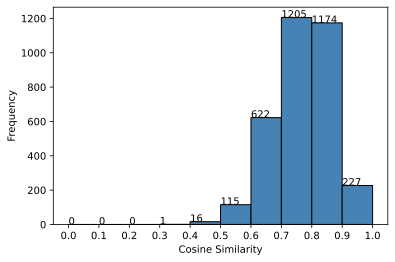

In [ ]:
print("corpus test average similarity:",torch.tensor(src_tar_scores).mean())

%config InlineBackend.figure_format='svg'#在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量

bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
picture = plt.hist(src_tar_scores,bins=bins,color='steelblue',edgecolor='black')#参数bin指明切分区间，左开右闭区间。
plt.xticks(np.arange(0, 1.1, 0.1))

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')


for a,b in zip(picture[1], (int(y_label) for y_label in picture[0])):
  plt.text(a,b,b)
#plt.savefig(data_path)

baseline average similarity: tensor(0.7517)


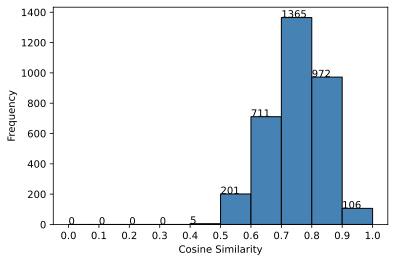

In [ ]:
print("baseline average similarity:",torch.tensor(base_src_top_id_scores).mean())

%config InlineBackend.figure_format='svg'#在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量

bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
picture = plt.hist(base_src_top_id_scores,bins=bins,color='steelblue',edgecolor='black')#参数bin指明切分区间，左开右闭区间。
plt.xticks(np.arange(0, 1.1, 0.1))

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')


for a,b in zip(picture[1], (int(y_label) for y_label in picture[0])):
  plt.text(a,b,b)
plt.savefig(data_path)

proposal average similarity: tensor(0.7580)


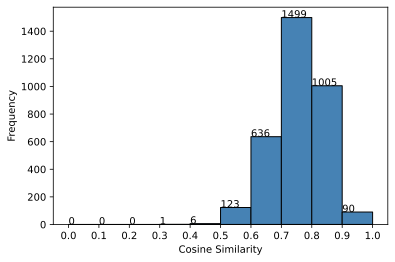

In [ ]:
print("proposal average similarity:",torch.tensor(proposal_src_top_id_scores).mean())

%config InlineBackend.figure_format='svg'#在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量

bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
picture = plt.hist(proposal_src_top_id_scores,bins=bins,color='steelblue',edgecolor='black')#参数bin指明切分区间，左开右闭区间。
plt.xticks(np.arange(0, 1.1, 0.1))

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')


for a,b in zip(picture[1], (int(y_label) for y_label in picture[0])):
  plt.text(a,b,b)
plt.savefig(data_path)